## Interpolation

Julia examples for Chapter 5, week 6.

The text writes functions for linear interpolation. Here we will use the Julia library Interpolants.

In [50]:
using Interpolations

In [51]:
xs = range(0, 3*pi, length = 19); # 0, pi/6, pi/3, etc
ys = sin.(xs);

In [52]:
interp_linear = linear_interpolation(xs, ys)
@show sin(pi/6)
@show interp_linear(pi/6) # exactly sin(pi/6) (as evaluated in floating point)
@show interp_linear(3.1) # approximately sin(3.1)
@show interp_linear(9.5) # outside grid: error

sin(pi / 6) = 0.49999999999999994
interp_linear(pi / 6) = 0.49999999999999994
interp_linear(3.1) = 0.03971805849074627


LoadError: BoundsError: attempt to access 19-element extrapolate(scale(interpolate(::Vector{Float64}, BSpline(Linear())), (0.0:0.5235987755982988:9.42477796076938,)), Throw()) with element type Float64 at index [9.5]

In [53]:
interp_cubic = cubic_spline_interpolation(xs, ys);

In [54]:
using Plots

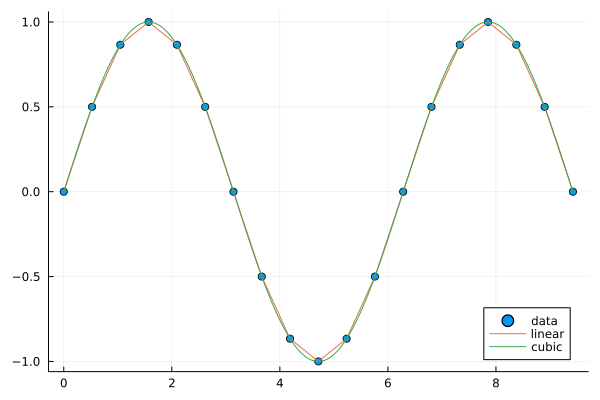

In [55]:
scatter(xs, ys, label = "data")
x2 = range(0, 3*pi, length= 2000);
plot!(x2, interp_linear.(x2), label = "linear")
plot!(x2, interp_cubic.(x2), label = "cubic")
# scatter!(x2, sin.(x2), label = "sin", markersize = 2.0, markercolor = "transparent")

Show errors.

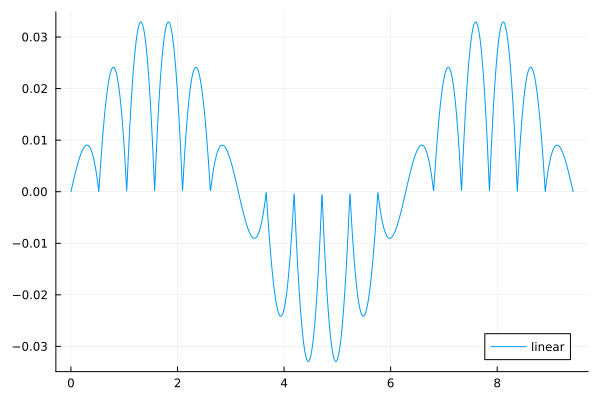

In [56]:
plot(x2, sin.(x2) .- interp_linear.(x2), label = "linear")

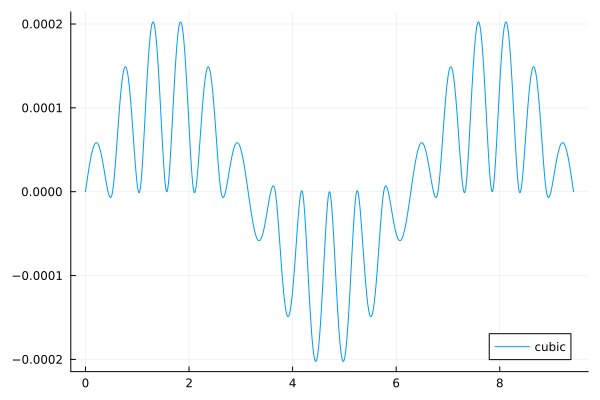

In [57]:
plot(x2, sin.(x2) .- interp_cubic.(x2), label = "cubic")

What is the error on the linear interpolation $p(x)$? Use Taylor's theorem or Mean Value Theorem (Exercise 5.2.5).

$$|f(x) - p(x)| = |f''(\xi)h^2| < Mh^2$$

where $h$ is the spacing between points.

To see this, compute a series of linear interpolations with different numbers of knots.

In [58]:
r = zeros(Float64, (9, 3))
for (i, k) in enumerate(2 .^ (3:11))
    xs = range(0, 3*pi, length = k)
    interp_linear = linear_interpolation(xs, sin.(xs))
    interp_cubic = cubic_spline_interpolation(xs, sin.(xs))
    r[i, 1] = xs[2] - xs[1]
    r[i, 2] = maximum(abs.(sin.(x2) .- interp_linear.(x2)))
    r[i, 3] = maximum(abs.(sin.(x2) .- interp_cubic.(x2)))
end

In [59]:
using PrettyTables
pretty_table(r, header = ["h", "linear", "cubic"])

┌────────────┬─────────────┬─────────────┐
│          h │      linear │       cubic │
├────────────┼─────────────┼─────────────┤
│     1.3464 │    0.218166 │   0.0130439 │
│   0.628319 │   0.0489432 │ 0.000447252 │
│   0.304025 │   0.0115289 │  2.27561e-5 │
│     0.1496 │  0.00279589 │  1.31136e-6 │
│  0.0742109 │ 0.000686317 │  7.87225e-8 │
│  0.0369599 │ 0.000170633 │  4.85782e-9 │
│  0.0184438 │  4.23059e-5 │  2.9977e-10 │
│ 0.00921288 │  1.05992e-5 │  1.8737e-11 │
│ 0.00460419 │  2.63705e-6 │ 1.16473e-12 │
└────────────┴─────────────┴─────────────┘


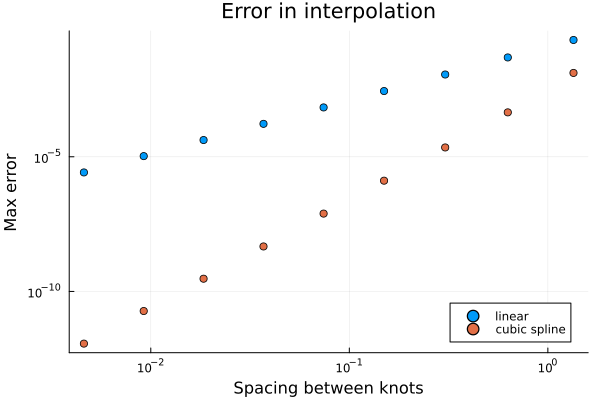

In [35]:
scatter(r[:, 1], r[:,2], yscale = :log10, xscale = :log10, label = "linear",
title = "Error in interpolation", xlabel = "Spacing between knots", ylabel = "Max error")
scatter!(r[:, 1], r[:,3], label = "cubic spline", legend = :bottomright)

Error is proportional to $h^2$ for linear and $h^4$ for cubic spline interpolation.

### Parametric curves

If $x(t)$ and $y(t)$ are cubic splines, or other interpolated functions, you can create parameterized curves.

The circle is deformed because of the way endpoints are managed by splines. Change the endpoint of the interpolation to fix this.

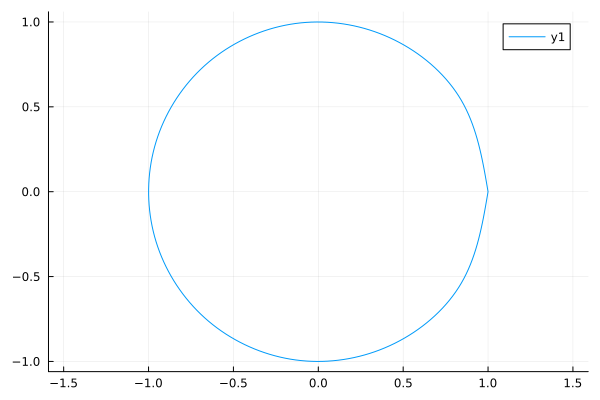

In [36]:
t = range(0*pi, 2*pi, length = 12)
xs = cos.(t)
ys = sin.(t)
x_cubic = cubic_spline_interpolation(t, xs);
y_cubic = cubic_spline_interpolation(t, ys);
t2 = range(0, 2*pi, length = 200)
plot(x_cubic.(t2), y_cubic.(t2), aspect_ratio = 1)

## Lagrange interpolations

Define the basis and use it to find an approximation to arbitrary data (possibly generated from a function.)

In [60]:
function lagrange_help(xs, k)
    ks = collect([0:k-1; k+1:length(xs)-1] .+ 1) # k is 0 indexed
    x -> prod(x - t for t in xs[ks])  
end
lagrange_basis(xs, k) = x -> lagrange_help(xs, k)(x) / lagrange_help(xs, k)(xs[k+1]);

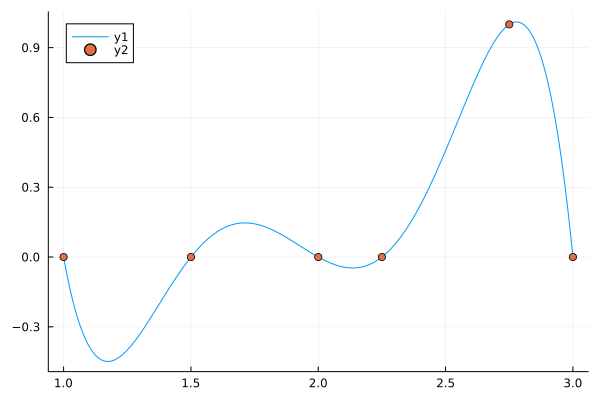

In [70]:
xs = [ 1, 1.5, 2, 2.25, 2.75, 3 ]
ys = 0 .* xs
k = 4
ys[k+1] = 1.0
# @show lagrange_help(xs, 5)(1.1)  # testing
plot(lagrange_basis(xs, k), 1, 3)
scatter!(xs, ys)

Interpolate some data generated from a function. Play with the period of the function to see examples that are easier or harder to interpolate.

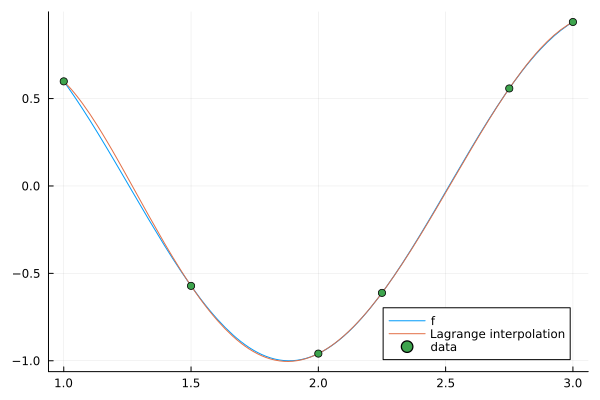

In [69]:
f3(x) = sin(2.5*x) 
ys = f3.(xs)
p(xs, ys) = x -> sum( ys[k]*lagrange_basis(xs, k-1)(x) for k in 1:length(xs) ) 
plot(f3, 1, 3, label = "f")
plot!(p(xs, ys), 1, 3, label = "Lagrange interpolation")
scatter!(xs, f3.(xs), label = "data")

## Finite differences

Define and test a few finite difference formulas.

In [40]:
forward_diff(f, x, h = sqrt(eps(x))) = (f(x+h)-f(x))/h
backward_diff(f, x, h = sqrt(eps(x))) = (f(x)-f(x-h))/h
centered_diff(f, x, h = sqrt(eps(x))) = (f(x+h)-f(x-h))/(2*h)

centered_diff (generic function with 2 methods)

In [41]:
f2(x) = 3*x^3+2*x - 1
df(x) = 9x^2+2
@show df(2.0)
@show forward_diff(f2, 2.0)
@show backward_diff(f2, 2.0)
@show centered_diff(f2, 2.0)

df(2.0) = 38.0
forward_diff(f2, 2.0) = 38.00000069835685
backward_diff(f2, 2.0) = 37.99999968683249
centered_diff(f2, 2.0) = 38.00000019259467


38.00000019259467

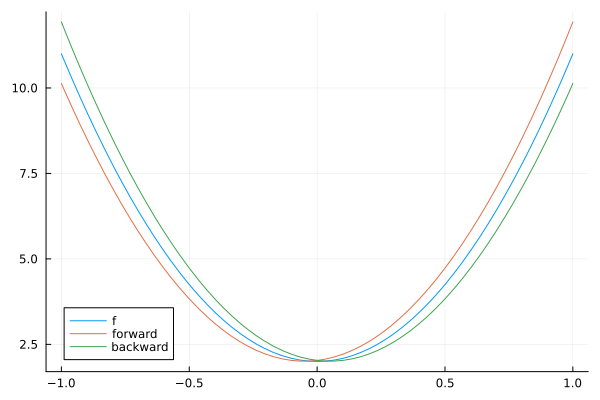

In [42]:
plot(df, -1, 1, label = "f")
plot!(x -> forward_diff(f2, x, 0.1), -1, 1, label = "forward")
plot!(x -> backward_diff(f2, x, 0.1), -1, 1, label = "backward")

Error as a function of h.

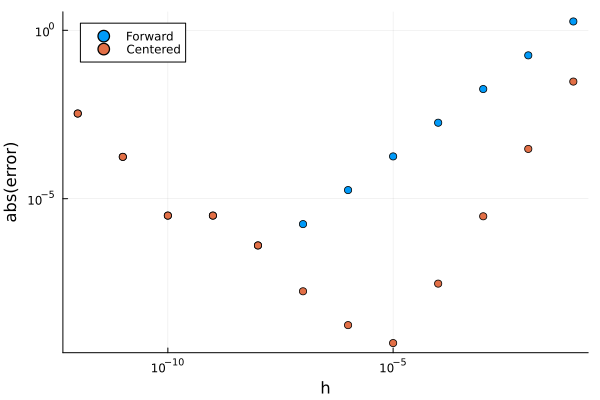

In [43]:
h = 10.0 .^ -(1:12)
error1 = df(2.0) .- forward_diff.(f2, 2.0, h);
error2 = df(2.0) .- centered_diff.(f2, 2.0, h);
scatter(h, abs.(error1), xlabel = "h", ylabel = "abs(error)", label = "Forward")
scatter!(h, abs.(error2), label = "Centered", xscale = :log10, yscale = :log10, legend = :topleft)


### Fornberg's algorithm

Using Lagrange polynomials for interpolation and differentiation. Derived in the [original publication](https://web.njit.edu/~jiang/math712/fornberg.pdf) from 1988. [A Julia implementation](https://github.com/bekaiser/Fornberg/blob/master/Lagrange_poly_derivatives.jl) that doesn't use recursion.

In [44]:
"""
    fdweights(t,m)

Compute weights for the `m`th derivative of a function at zero using
values at the nodes in vector `t`.
"""
function fdweights(t,m)
# This is a compact implementation, not an efficient one.
    # Recursion for one weight. 
    function weight(t,m,r,k)
        # Inputs
        #   t: vector of nodes 
        #   m: order of derivative sought 
        #   r: number of nodes to use from t 
        #   k: index of node whose weight is found

        if (m<0) || (m>r)        # undefined coeffs must be zero
            c = 0
        elseif (m==0) && (r==0)  # base case of one-point interpolation
            c = 1
        else                     # generic recursion
            if k<r
                c = (t[r+1]*weight(t,m,r-1,k) -
                    m*weight(t,m-1,r-1,k))/(t[r+1]-t[k+1])
            else
                numer = r > 1 ? prod(t[r]-x for x in t[1:r-1]) : 1
                denom = r > 0 ? prod(t[r+1]-x for x in t[1:r]) : 1
                β = numer/denom
                c = β*(m*weight(t,m-1,r-1,r-1) - t[r]*weight(t,m,r-1,r-1))
            end
        end
        return c
    end
    r = length(t)-1
    w = zeros(size(t))
    return [ weight(t,m,r,k) for k=0:r ]
end


fdweights

In [45]:
t = [ 0.25,0.45,0.55,0.75 ]   # nodes chosen at random; symmetry and close spacing helps
f = x -> sin(exp(x))
dfdx = x -> cos(exp(x))*exp(x)
@show exact_value = dfdx(0.5)
@show w = fdweights(t.-0.5,1)
@show fd_value = w' * f.(t);

exact_value = dfdx(0.5) = -0.12834652741859814
w = fdweights(t .- 0.5, 1) = [0.08333333333333291, -10.416666666666664, 10.416666666666666, -0.08333333333333387]
fd_value = w' * f.(t) = -0.12840342495850976


Using rational numbers we can obtain the coefficients in the tables.

In [46]:
@show fdweights(Rational.(-1:1),1);
@show fdweights(Rational.(-2:2),1);
@show fdweights(Rational.(0:4),1);

fdweights(Rational.(-1:1), 1) = Rational{Int64}[-1//2, 0//1, 1//2]
fdweights(Rational.(-2:2), 1) = Rational{Int64}[1//12, -2//3, 0//1, 2//3, -1//12]
fdweights(Rational.(0:4), 1) = Rational{Int64}[-25//12, 4//1, -3//1, 4//3, -1//4]


Second derivatives

In [47]:
@show fdweights(Rational.(-1:1),2);
@show fdweights(Rational.(-2:2),2);
@show fdweights(Rational.(0:4),2);

fdweights(Rational.(-1:1), 2) = Rational{Int64}[1//1, -2//1, 1//1]
fdweights(Rational.(-2:2), 2) = Rational{Int64}[-1//12, 4//3, -5//2, 4//3, -1//12]
fdweights(Rational.(0:4), 2) = Rational{Int64}[35//12, -26//3, 19//2, -14//3, 11//12]
